# Simple PINN for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L], t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 0
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

## Spacial and time domains

We represent the inner points in space and time by a set of collocation points.

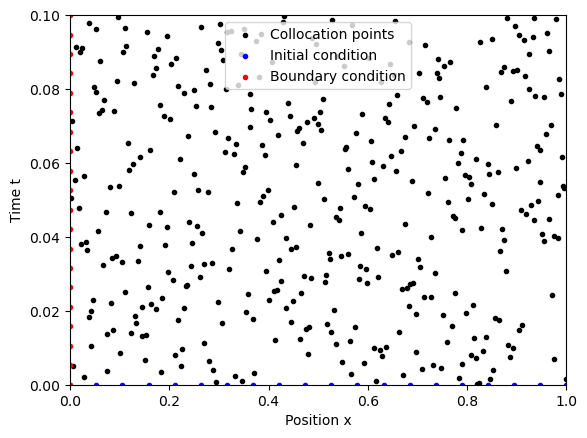

In [1]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from global_constants import L, Z, alpha

# Compute collocation points on domain
N = 20
points = qmc.LatinHypercube(d=2).random(N**2).astype(np.float32)
points[:,0] = points[:,0] * L
points[:,1] = points[:,1] * Z

# Initial points and prescribed initial values
x = np.linspace(0, L, N)
t0 = np.zeros_like(x)
Tt0 = np.cos(2.0*np.pi*x)

# Boundary points and prescribed boundary values
t = np.linspace(0, Z, N)
x0 = np.zeros_like(t)
Tx0 = np.ones_like(t)

# Build dataset for training
input_data = tf.concat([tf.stack([x, t0], axis=1), tf.stack([x0, t], axis=1)], axis=0)
output_data = tf.concat([Tt0, Tx0], axis=0)

# Visualize locations of all training points
plt.scatter(points[:,0], points[:,1], c="k", marker=".")
plt.scatter(x, t0, c="b", marker=".")
plt.scatter(x0, t, c="r", marker=".")
plt.xlabel("Position x")
plt.xlim([0, L])
plt.ylabel("Time t")
plt.ylim([0, Z])
plt.legend(["Collocation points", "Initial condition", "Boundary condition"])

## The ANN model that approximates the function T

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $T: \mathcal{R}^2 \rightarrow \mathcal{R}$ with five hidden layers having 10 neurons each.

![ann](ann.png)

In [2]:
# build a dense multi-layer perceptron ANN to approximate the temperature
# Input are x and t, output is T
model = keras.models.Sequential()
model.add(keras.Input(shape=(2,), name="input"))
for i in range(5):
    model.add(keras.layers.Dense(10, activation="tanh", name=f"hidden-{i}"))
model.add(keras.layers.Dense(1, activation="linear", name="output"))

## Evaluate physics-informed loss

The pysics-informed part of the PINN is achieved by including the residual of an PDE as loss function. To compute that loss, we use automatic differentiation to obtain gradients of $T$. The loss function is then
$$
    \mathcal{L} = \mathcal{L}_\text{DATA} + W \mathcal{L}_\text{PDE}
$$
with 
$$
    \mathcal{L}_\text{DATA} = \frac{1}{N} \sum_{i=1}^{N} || \hat{T}(x_0, t_0) - T_0 ||^2
$$
at the boundary points and intial points and 
$$
    \mathcal{L}_\text{PDE} = \frac{1}{N} \sum_{i=1}^{N} || \frac{\partial T}{\partial t} - \alpha \Delta T ||^2
$$
in the timespace domain. the hyperparameter $W$ determines the weight of the PDE residual in comparison to the data residual.

In [3]:
# Hyperparameter to weight the PDE loss
W = 0.01

@tf.function
def pde_residual(x, t):
    x = tf.convert_to_tensor(x)
    t = tf.convert_to_tensor(t)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        T = model(tf.stack([x, t], axis=1))
        T_x = tape.gradient(T, x)
        T_t = tape.gradient(T, t)
    T_xx = tape.gradient(T_x, x)
    del tape 
    return T_t - alpha * T_xx

def custom_loss(timespace):
    def loss(true, prediction):
        residual = pde_residual(timespace[:, 0], timespace[:, 1])
        # loss from physics residual
        pde_loss = tf.reduce_mean(tf.square(residual))
        # loss from boundaries and initial values
        data_loss = tf.reduce_mean(tf.square(true - prediction))
        return data_loss + W * pde_loss
    return loss

## Compile and train the PINN 
We adjust the weights such that the loss is minimized over several epochs.

In [4]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=custom_loss(points))
history = model.fit(input_data, output_data, epochs=50000, verbose=0)


2023-03-19 13:02:55.306495: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


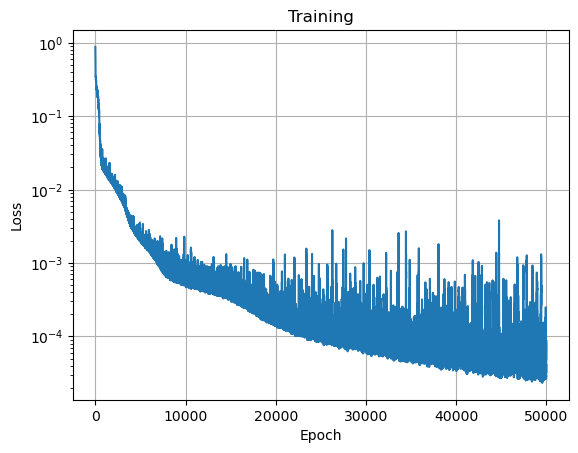

4/4 [==============================] - 0s 755us/step


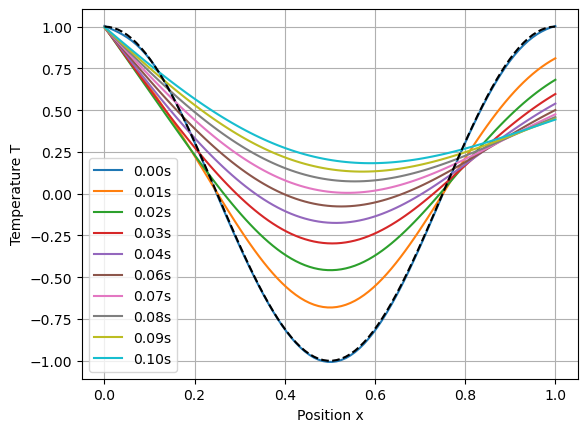

In [5]:
# Plot history of optimization
plt.semilogy(history.history["loss"])
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid("both")
plt.show()

# Plot results
for i in range(10):
    val_x = np.linspace(0, L, 100)
    val_t = 0.01 * i * np.ones_like(val_x)
    val_domain = np.stack([val_x, val_t], axis=1)
    T = model.predict(val_domain)
    plt.plot(val_x, T)
plt.plot(val_x, np.cos(2.0*np.pi*val_x), "--k")
plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10) ])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()
plt.show()